In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

In [2]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# path='/content/drive/My Drive/praca_mgr'
# os.chdir(path)

###  Loading data

In [3]:
# data = np.load('./data/conditional_data_nonrandom.npz')["arr_0"]

data = np.load('../../conditional_data_nonrandom.npz')["arr_0"]
data = pd.DataFrame(data, columns =['Energy','Vx','Vy',	'Vz','Px','Py','Pz','mass','charge'])
data["nonrandom"]=1
data.shape

(295867, 10)

In [4]:
#data0 = np.load('./data/conditional_data_random.npz')["arr_0"]

data0 = np.load('../../conditional_data_random.npz')["arr_0"]
data0 = pd.DataFrame(data0, columns =['Energy','Vx','Vy','Vz','Px',	'Py','Pz','mass','charge']).sample(replace=True,frac=3)
data0["nonrandom"]=0
data0.shape

(300924, 10)

In [5]:
data = pd.concat([data,data0]).sample(frac=1)
data.head()

Energy        Vx            Vy        Vz        Px        Py  \
29686  1109.3500  0.000000  0.000000e+00  0.000000 -0.303946 -0.600251   
29953   416.2070  0.000003  6.891890e-06  0.026257  0.014656  0.164749   
3288     80.8463 -0.000004 -2.765220e-06 -0.016319 -0.030721  0.011251   
57606  1022.4900  0.000011  3.186020e-07 -0.081157  0.084393  0.004909   
32522   462.1580  0.000000  0.000000e+00  0.000000 -0.059635 -0.223428   

              Pz         mass  charge  nonrandom  
29686 -1109.3500  1189.370000    -1.0          1  
29953   416.2070     0.000000     0.0          1  
3288    -80.8463     0.000000     0.0          0  
57606 -1022.4900     0.000000     0.0          1  
32522  -462.1570   939.565413     0.0          0

### Visualisation of features that allow for a good separation of classes

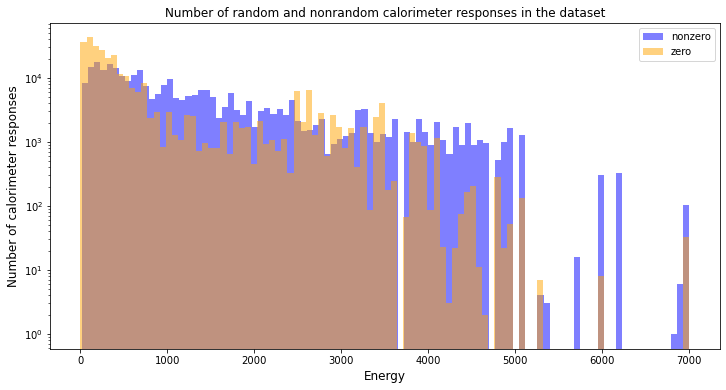

In [6]:
plt.figure(figsize=(12, 6))
plt.title("Number of random and nonrandom calorimeter responses in the dataset")
plt.hist(data['Energy'][data['nonrandom']==1],bins=100, alpha=0.5, color="blue")
plt.hist(data['Energy'][data['nonrandom']==0],bins=100, alpha=0.5, color="orange")
plt.legend(["nonzero","zero"])
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Number of calorimeter responses', fontsize=12)
plt.yscale("log")
plt.show()

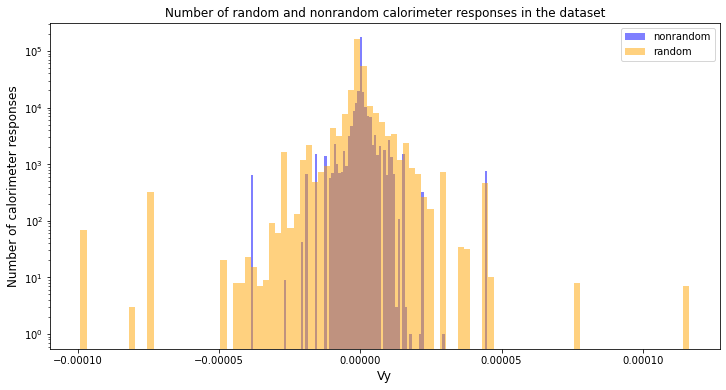

In [7]:
plt.figure(figsize=(12, 6))
plt.title("Number of random and nonrandom calorimeter responses in the dataset")
plt.hist(data['Vy'][data['nonrandom']==1],bins=100, alpha=0.5, color="blue")
plt.hist(data['Vy'][data['nonrandom']==0],bins=100, alpha=0.5, color="orange")
plt.legend(["nonrandom","random"])
plt.xlabel('Vy', fontsize=12)
plt.ylabel('Number of calorimeter responses', fontsize=12)
plt.yscale("log")
plt.show()

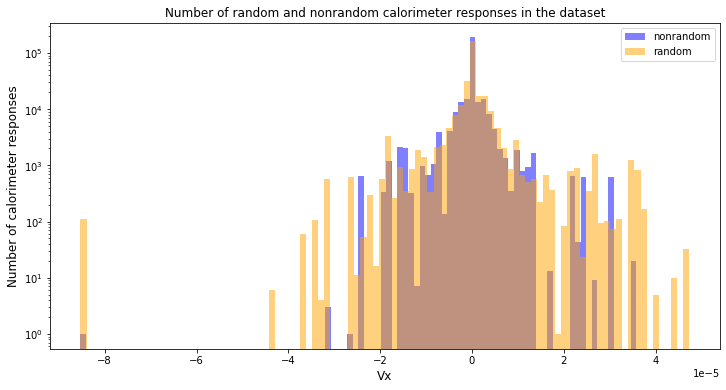

In [8]:
plt.figure(figsize=(12, 6))
plt.title("Number of random and nonrandom calorimeter responses in the dataset")
plt.hist(data['Vx'][data['nonrandom']==1],bins=100, alpha=0.5, color="blue")
plt.hist(data['Vx'][data['nonrandom']==0],bins=100, alpha=0.5, color="orange")
plt.legend(["nonrandom","random"])
plt.xlabel('Vx', fontsize=12)
plt.ylabel('Number of calorimeter responses', fontsize=12)
plt.yscale("log")
plt.show()

### Defining, training and evaluating the model

In [9]:
target = data['nonrandom']

train = data.iloc[:int(data.shape[0]*0.75),:-1]
train_y = target.iloc[:int(data.shape[0]*0.75)]
test = data.iloc[int(data.shape[0]*0.75):,:-1]
test_y = target.iloc[int(data.shape[0]*0.75):]

sc = preprocessing.MinMaxScaler()
ttrain = sc.fit_transform(train)
ttest = sc.transform(test)

In [10]:
train.mean()

Energy    1.071001e+03
Vx        9.795600e-08
Vy        4.598783e-09
Vz        3.157082e-04
Px        4.736525e-03
Py        6.037059e-03
Pz        5.867702e+01
mass      2.799301e+02
charge    1.145326e-01
dtype: float64

In [11]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
clf.fit(ttrain, train_y)
pred = clf.predict_proba(ttest)[:,1]
pred=(pred>0.5).astype('int')

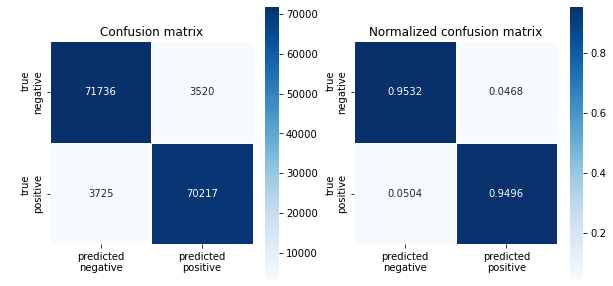

In [12]:
conf = confusion_matrix(test_y,pred)
plt.figure(figsize=(10,5))
plt.subplot(121)
x =  pd.DataFrame(conf)
x.columns = ["predicted\nnegative", "predicted\npositive"]
x[" "]=["true\nnegative", "true\npositive"]
x = x.set_index(' ')
plt.title('Confusion matrix')
sns.heatmap(x, annot=True, fmt="d", cmap="Blues", linewidths=.5, square = True)
plt.subplot(122)
conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
x =  pd.DataFrame(conf)
x.columns = ["predicted\nnegative", "predicted\npositive"]
x[" "]=["true\nnegative", "true\npositive"]
x = x.set_index(' ')
plt.title('Normalized confusion matrix')
sns.heatmap(x, annot=True, fmt=".4f", cmap="Blues", linewidths=.5, square = True)
plt.show()

In [13]:
import sklearn
print(sklearn.metrics.classification_report(test_y,pred, target_names=["random", "nonrandom"]))

              precision    recall  f1-score   support

      random       0.95      0.95      0.95     75256
   nonrandom       0.95      0.95      0.95     73942

    accuracy                           0.95    149198
   macro avg       0.95      0.95      0.95    149198
weighted avg       0.95      0.95      0.95    149198



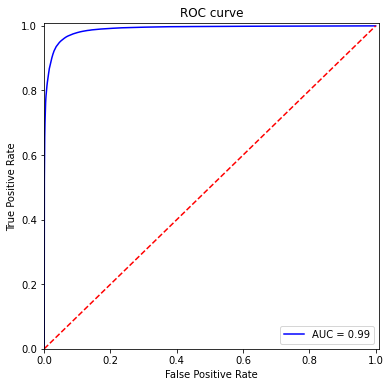

In [14]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(test_y, clf.predict_proba(ttest)[:,1])
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6, 6))
# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()